# fMRI-02 Exercises

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

Today's demonstration will be in two parts. In the first section, we will show you how to generate the predicted BOLD signal for analysis of a rapid event related design experiment. We will also show the sensitivity of these experiments to assumptions in the HRF. In the second section, we will discuss estimation efficiency and finite impulse response (FIR) designs.

## Part 1: Generating the predicted BOLD signal

In this first section, we will generate the predicted BOLD signal for a simple rapid event related (RER) experiment. In RER experiments, we have to consider two important design details: 
1. The order of trials
2. The order of null events

In this first example, we will provide for you a pre-optimized RER experiment design. In this experiment, we have two conditions. Each condition has 60 trials, and each trial lasts 1 second in duration. The total experiment length is 240 seconds. Let's make the design matrix for this experiment.

### [1] Define (super-sampled) times
Here we define the timing of the experiment. Importantly we first define the experiment in a "super-sampled" space, or we act like we have acquired far more data points than we actually have. We do this for several reasons. First, it functions to reduce the noisiness of our convolved regressors (more on that in a minute). Second, it allows us to model events that occur between TRs.

In [2]:
## Define experiment metadata.
n_times = 240
sfreq = 0.1

## Define (super-sampled) times.
sst = np.arange(0, n_times, sfreq)

### [2] Generate boxcars
Here we define a "boxcar" timeseries. In this step we make a binary timeseries (comprised of 0s and 1s), where 0s represent neuronal silence and 1s represent neuronal activity. Essentially, we initialize a timeseries that is as long as the number of times defined above, where the value of the timeseries is 1 if we expect the neurons to be active in that minute, and 0 otherwise. The term boxcar comes from the boxy pattern that results from this process.

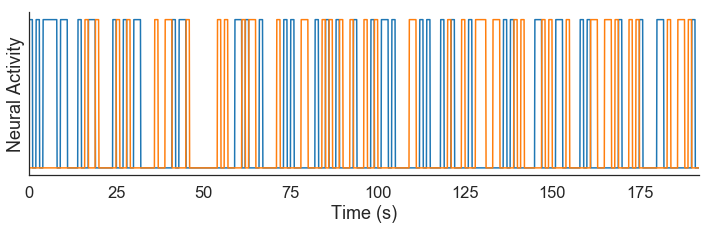

In [3]:
## Load experimental events.
npz = np.load('fmri-03-rer.npz')
events = npz['events']
events[:, -1] -= 1

## Generate boxcars.
boxcars = np.zeros((sst.size, 2))
for onset, offset, cond in events:
    boxcars[np.logical_and(sst >= onset, sst < offset), int(cond)] = 1
    
## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(sst, boxcars);
ax.set(xlim=(0,192), xlabel='Time (s)', yticks=[], ylabel='Neural Activity')
sns.despine()

### [3] Define the HRF
In the previous class, we saw that that the hemodynamic response can be variable in shape. In this step, we define the expected shape of the HRF. We typically fall back on early imaging experiments showing that, under many experimental conditions, the HRF has a stereotyped shape. This is the **SPM HRF**. 

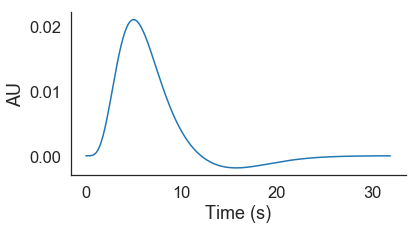

In [4]:
from fmritools.hrf import spm_hrf

## Define HRF.
hrf = spm_hrf(sfreq)

## Plot.
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(sst[:hrf.size], hrf);
ax.set(xlabel='Time (s)', ylabel='AU')
sns.despine()

### [4] Convolution


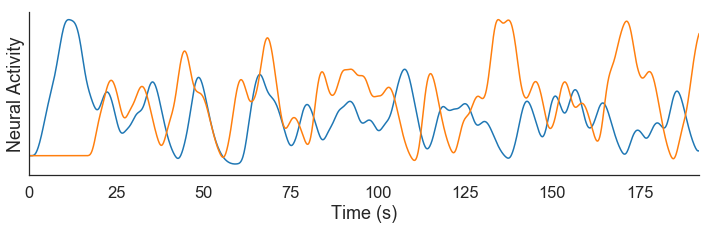

In [5]:
## Convolve boxcars + HRF.
bold = np.apply_along_axis(np.convolve, 0, boxcars, hrf)[:sst.size]

## Normalize regressor.
bold /= bold.max(axis=0)

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(sst, bold);
ax.set(xlim=(0,192), xlabel='Time (s)', yticks=[], ylabel='Neural Activity')
sns.despine()

### [5] Downsampling

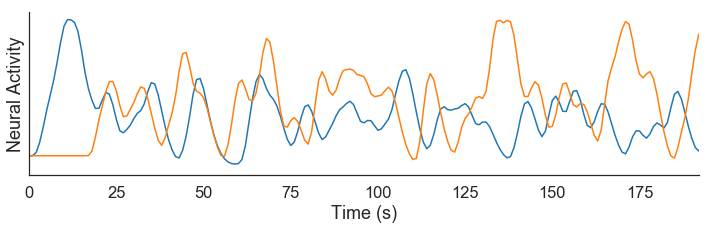

In [6]:
## Define observation times.
tr = 1
times = np.arange(n_times) * tr

## Define downsampling indices.
ix = np.in1d(sst, times)

## Downsampling.
boxcars = boxcars[ix]
bold = bold[ix]

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(times, bold);
ax.set(xlim=(0,192), xlabel='Time (s)', yticks=[], ylabel='Neural Activity')
sns.despine()

## Part 1.5: Simple Regression

### [1] Load and visualize data

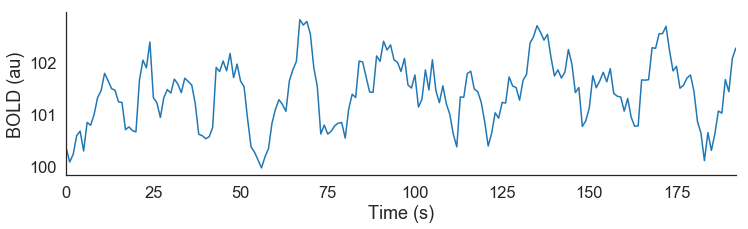

In [7]:
## Load and extract data.
y = npz['y1']

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(times, y);
ax.set(xlim=(0,192), xlabel='Time (s)', ylabel='BOLD (au)')
sns.despine()

### [2] Construct design matrix

In [8]:
X = np.column_stack([np.ones(times.size), bold])

### [3] Regression

b1 = 1.522, b2 = 2.452


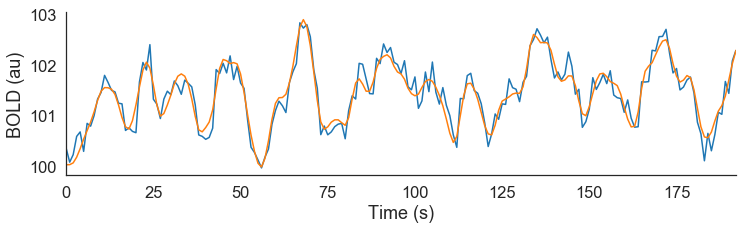

In [9]:
## Perform regression.
b, _, _, _ = np.linalg.lstsq(X, y, rcond=-1)
print('b1 = %0.3f, b2 = %0.3f' %(b[1], b[2]))

## Posterior predictive check.
yhat = X @ b

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(times, y);
ax.plot(times, yhat);
ax.set(xlim=(0,192), xlabel='Time (s)', ylabel='BOLD (au)')
sns.despine()

### [4] Sensitivity to HRF

b1 = 1.247, b2 = 2.153


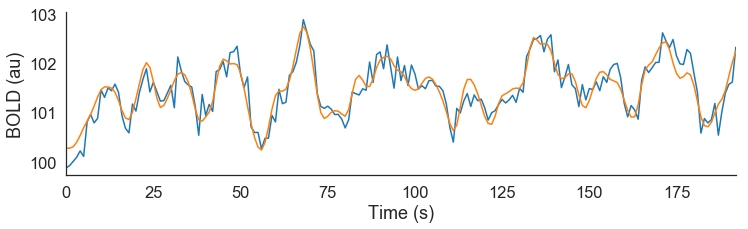

In [10]:
## Load and extract data.
y = npz['y2']

## Perform regression.
b, _, _, _ = np.linalg.lstsq(X, y, rcond=-1)
print('b1 = %0.3f, b2 = %0.3f' %(b[1], b[2]))

## Posterior predictive check.
yhat = X @ b

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(times, y);
ax.plot(times, yhat);
ax.set(xlim=(0,192), xlabel='Time (s)', ylabel='BOLD (au)')
sns.despine()